In [8]:
# Installs necessary to utilize the dataset and pre-training
!pip install kaggle
!pip install timm==0.6.13

In [9]:
# Imports all necessary functions
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
from torchvision.models import ResNet50_Weights, MobileNet_V3_Large_Weights
from torchvision.datasets import ImageFolder
from google.colab import drive

import timm
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [10]:
# Used to access google drive, for storage and dataset extraction.
drive.mount('/content/drive')

# Copies kaggle.json to Colab and configure Kaggle API
!cp '/content/drive/Mydrive/kaggle.json' '/content/'
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ankit1743/skyview-an-aerial-landscape-dataset
!unzip skyview-an-aerial-landscape-dataset.zip -d /content/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/content/drive/Mydrive/kaggle.json': No such file or directory
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/ankit1743/skyview-an-aerial-landscape-dataset
License(s): CC0-1.0
skyview-an-aerial-landscape-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  skyview-an-aerial-landscape-dataset.zip
replace /content/Aerial_Landscapes/Agriculture/001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Training ResNet50...


Training ResNet50 (Epoch 1/3): 100%|██████████| 300/300 [00:34<00:00,  8.65it/s]


Epoch 1, Train Loss: 1.8867, Val Loss: 1.7834, Val Accuracy: 47.08%, Test Accuracy: 43.42%
Model improved, saved to ResNet50_checkpoint.pth


Training ResNet50 (Epoch 2/3): 100%|██████████| 300/300 [00:34<00:00,  8.81it/s]


Epoch 2, Train Loss: 1.4472, Val Loss: 1.5891, Val Accuracy: 50.25%, Test Accuracy: 45.83%
Model improved, saved to ResNet50_checkpoint.pth


Training ResNet50 (Epoch 3/3): 100%|██████████| 300/300 [00:33<00:00,  8.83it/s]


Epoch 3, Train Loss: 1.2779, Val Loss: 1.2490, Val Accuracy: 57.17%, Test Accuracy: 57.92%
Model improved, saved to ResNet50_checkpoint.pth
Training MobileNetV3...


Training MobileNetV3 (Epoch 1/3): 100%|██████████| 300/300 [00:31<00:00,  9.53it/s]


Epoch 1, Train Loss: 1.6868, Val Loss: 3.0720, Val Accuracy: 5.50%, Test Accuracy: 7.50%
Model improved, saved to MobileNetV3_checkpoint.pth


Training MobileNetV3 (Epoch 2/3): 100%|██████████| 300/300 [00:31<00:00,  9.47it/s]


Epoch 2, Train Loss: 1.2536, Val Loss: 2.6116, Val Accuracy: 12.75%, Test Accuracy: 13.25%
Model improved, saved to MobileNetV3_checkpoint.pth


Training MobileNetV3 (Epoch 3/3): 100%|██████████| 300/300 [00:31<00:00,  9.54it/s]


Epoch 3, Train Loss: 1.0853, Val Loss: 1.9314, Val Accuracy: 26.50%, Test Accuracy: 26.92%
Model improved, saved to MobileNetV3_checkpoint.pth
Training EfficientNetV2_S...


Training EfficientNetV2_S (Epoch 1/3): 100%|██████████| 300/300 [00:47<00:00,  6.36it/s]


Epoch 1, Train Loss: 2.1034, Val Loss: 1.9094, Val Accuracy: 34.75%, Test Accuracy: 34.00%
Model improved, saved to EfficientNetV2_S_checkpoint.pth


Training EfficientNetV2_S (Epoch 2/3): 100%|██████████| 300/300 [00:46<00:00,  6.39it/s]


Epoch 2, Train Loss: 1.6720, Val Loss: 1.7862, Val Accuracy: 48.42%, Test Accuracy: 44.58%
Model improved, saved to EfficientNetV2_S_checkpoint.pth


Training EfficientNetV2_S (Epoch 3/3): 100%|██████████| 300/300 [00:46<00:00,  6.41it/s]


Epoch 3, Train Loss: 1.4721, Val Loss: 2.0596, Val Accuracy: 49.83%, Test Accuracy: 48.50%


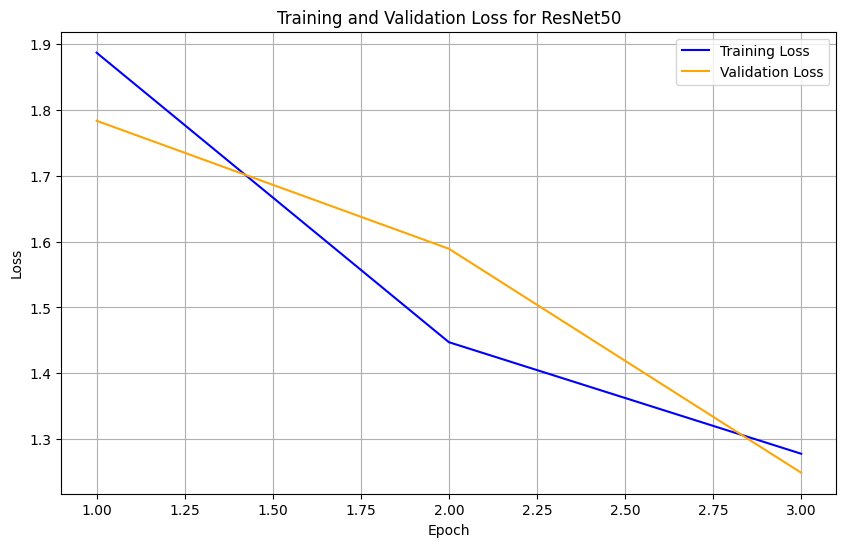

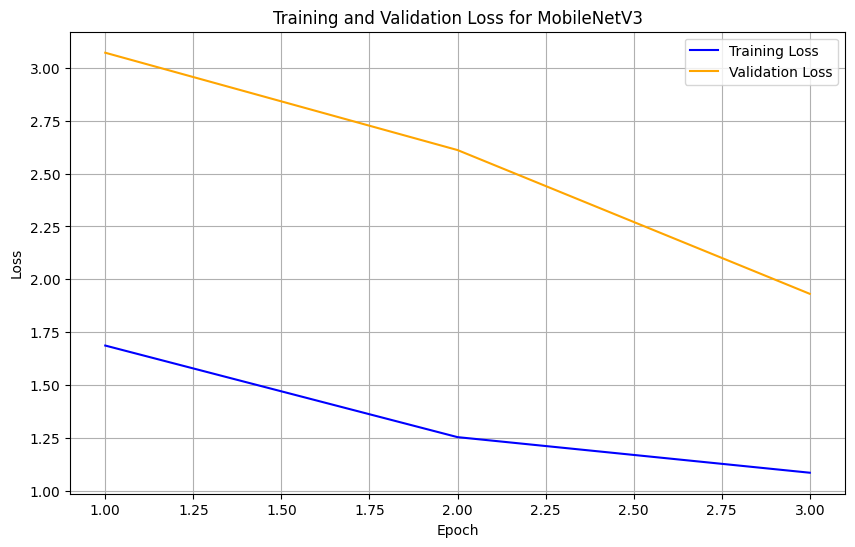

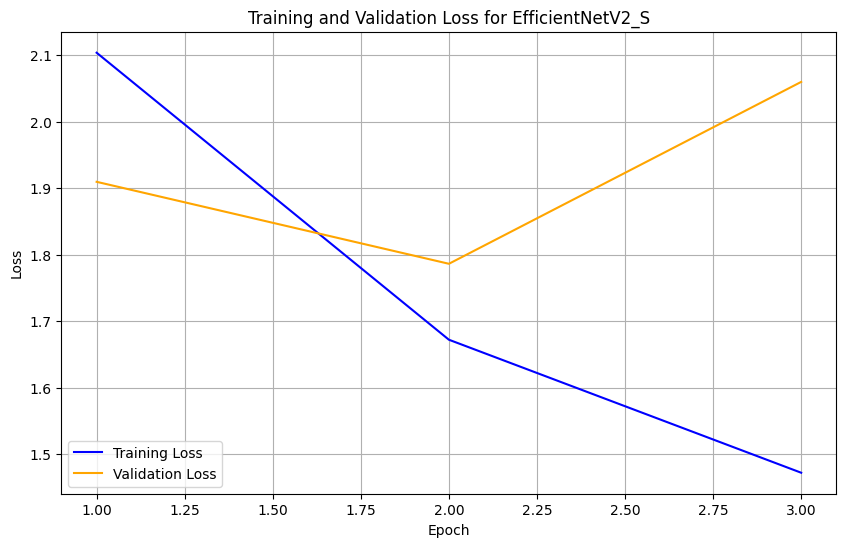

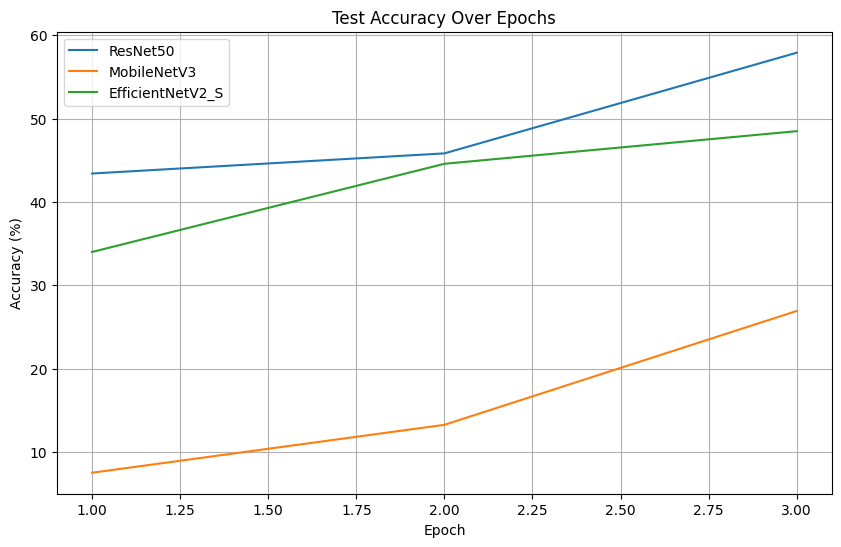

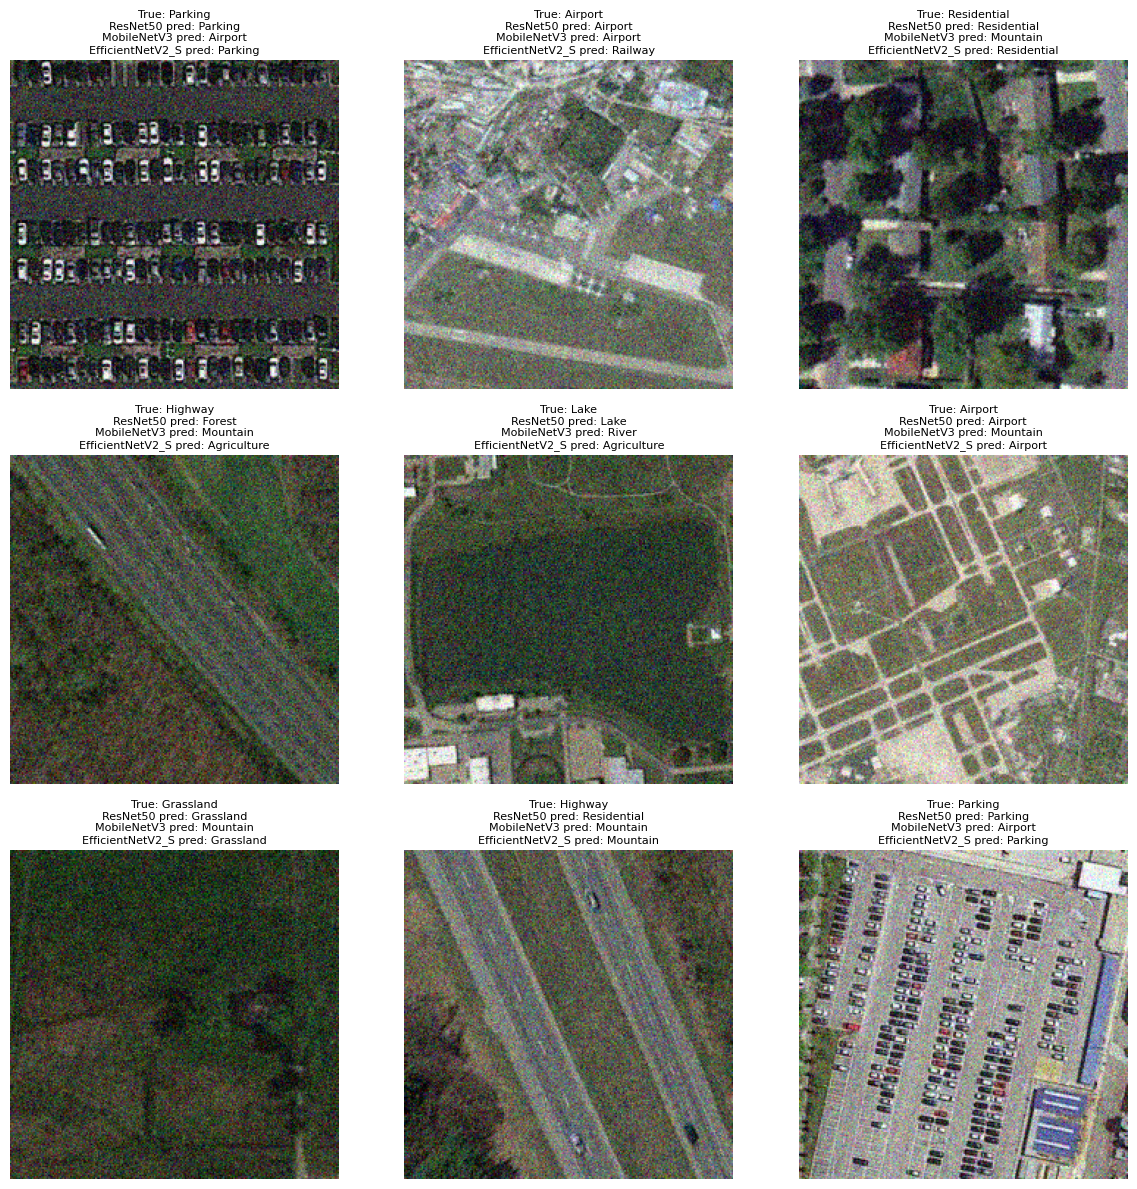

In [11]:
# Dataset path (in google drive)
dataset_path = '/content/Aerial_Landscapes'

# Training parameters
batch_size = 32
learning_rate = 0.001
num_epochs = 20

# C2: Cutout augmentation
class Cutout:
    def __init__(self, num_holes, hole_size):
        self.num_holes = num_holes
        self.hole_size = hole_size

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = torch.ones((h, w), dtype=torch.float32)

        for _ in range(self.num_holes):
            y = random.randint(0, h)
            x = random.randint(0, w)

            y1 = max(0, y - self.hole_size // 2)
            y2 = min(h, y + self.hole_size // 2)
            x1 = max(0, x - self.hole_size // 2)
            x2 = min(w, x + self.hole_size // 2)

            mask[y1:y2, x1:x2] = 0

        img = img * mask.unsqueeze(0)
        return img

# Defining transformations so they fit all models
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    Cutout(num_holes=1, hole_size=32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loads the dataset and category names
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=train_transform)
class_names = dataset.classes
num_classes = len(class_names)

# Splits the dataset into training, validation, and test sets: 80%, 10% and 10% respectively
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# C1: Transforms for validation and test sets
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #Shuffles training data to increase robustness/generalization
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) #Shuffling = false to maintain consistent evaluation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #Shuffling = false to maintain consistent testing of performance

# B: Defines models, the pre-trained weights used are behind the following hashtag
models_dict = {
    "ResNet50": models.resnet50(weights=None), #models.ResNet50_Weights.IMAGENET1K_V2
    "MobileNetV3": models.mobilenet_v3_large(weights=None), #models.MobileNet_V3_Large_Weights.IMAGENET1K_V1
    "EfficientNetV2_S": models.efficientnet_v2_s(weights=None) #True
}

# Modifies the final fully connected layer to the correct number of classes
for model_name, model in models_dict.items():
    if model_name == "EfficientNetV2_S":
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "MobileNetV3":
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)
    else:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

# C: Implementing Early Stopping and saving the best epoch
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.01, checkpoint_path="checkpoint.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.checkpoint_path = checkpoint_path

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.checkpoint_path)
            print(f"Model improved, saved to {self.checkpoint_path}")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to add Gaussian noise used in testing
def add_gaussian_noise(inputs, mean=0.0, std=0.1):
    noise = torch.randn_like(inputs) * std + mean
    return inputs + noise


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Uses GPU if available, as GPU is much faster for training deep learning models

# Storage for training, validation, and tests
train_losses = {model_name: [] for model_name in models_dict}
val_losses = {model_name: [] for model_name in models_dict}
val_accuracies = {model_name: [] for model_name in models_dict}
test_accuracies_per_epoch = {model_name: [] for model_name in models_dict}

# Training, validation and test loop
for model_name, model in models_dict.items():
    print(f"Training {model_name}...")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

    early_stopping = EarlyStopping(patience=3, min_delta=0.01, checkpoint_path=f"{model_name}_checkpoint.pth")

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Training {model_name} (Epoch {epoch+1}/{num_epochs})"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses[model_name].append(avg_train_loss)

        # Stores and evaluates the validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses[model_name].append(avg_val_loss)
        val_accuracy = 100 * correct_val / total_val
        val_accuracies[model_name].append(val_accuracy)

        # Engages the test phase and prints results
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_accuracies_per_epoch[model_name].append(test_accuracy)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered for {model_name}")
            break

# Plot training and validation loss for each model
for model_name in models_dict.keys():
    epochs = range(1, len(train_losses[model_name]) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses[model_name], label="Training Loss", color='blue')
    plt.plot(epochs, val_losses[model_name], label="Validation Loss", color='orange')
    plt.title(f"Training and Validation Loss for {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()


# Plot test accuracy for all models
plt.figure(figsize=(10, 6))
for model_name, accuracies in test_accuracies_per_epoch.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=model_name)
plt.title("Test Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

# Plot example images with predictions from all models
num_images_to_plot = 5
sample_inputs, sample_labels = [], []
predictions_per_model = {model_name: [] for model_name in models_dict.keys()}

# Collect predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        for model_name, model in models_dict.items():
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            predictions_per_model[model_name].extend(predictions.cpu().numpy())

        sample_inputs.extend(inputs.cpu())
        sample_labels.extend(labels.cpu())

        if len(sample_inputs) >= num_images_to_plot:
            break

# Transforms the images back to normal while keeping noise, and plots them in a 3x3 grid
num_images_to_plot = 9
sample_inputs, sample_labels = [], []
predictions_per_model = {model_name: [] for model_name in models_dict.keys()}

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        for model_name, model in models_dict.items():
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            predictions_per_model[model_name].extend(predictions.cpu().numpy())

        sample_inputs.extend(inputs.cpu())
        sample_labels.extend(labels.cpu())

        if len(sample_inputs) >= num_images_to_plot:
            break

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for idx in range(num_images_to_plot):
    row, col = divmod(idx, 3)
    image = sample_inputs[idx].permute(1, 2, 0).numpy()
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    image = std * image + mean
    image = image.clip(0, 1)

    # Add back the noise using the earlier noise function
    noisy_image = add_gaussian_noise(torch.tensor(image).permute(2, 0, 1)).permute(1, 2, 0).numpy()
    noisy_image = noisy_image.clip(0, 1)

    # Plot the noisy image with label and the models prediction
    axes[row, col].imshow(noisy_image)
    axes[row, col].axis("off")

    predictions_text = "\n".join([f"{model_name} pred: {class_names[predictions_per_model[model_name][idx]]}"
                                  for model_name in models_dict.keys()])
    axes[row, col].set_title(f"True: {class_names[sample_labels[idx].item()]}\n{predictions_text}", fontsize=8)

plt.tight_layout()
plt.show()